In [119]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import copy

from sklearn.model_selection import train_test_split, StratifiedShuffleSplit

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

from pandas_profiling import ProfileReport

import xgboost as xgb

from hyperopt import STATUS_OK, hp, tpe, fmin, space_eval, Trials

In [120]:
# read data

data = pd.read_csv("data.csv")

In [121]:
data.head()

,target,v_cont_0,v_cat_0,v_cat_1,v_cat_2,v_cat_3,v_cont_5,v_cont_6,v_cont_7,v_cont_8,...,v_cont_117,v_cont_118,v_cont_119,v_cont_120,v_cont_121,v_cont_122,v_cont_123,v_cont_124,v_cont_125,v_cont_126
0,0.20,8,NaN,NaN,Lakewoodcity,1,0.19,0.33,0.02,0.90,...,0.29,0.12,0.26,0.20,0.06,0.04,0.9,0.5,0.32,0.14
1,0.67,53,NaN,NaN,Tukwilacity,1,0.00,0.16,0.12,0.74,...,NaN,0.02,0.12,0.45,NaN,NaN,NaN,NaN,0.00,NaN
2,0.43,24,NaN,NaN,Aberdeentown,1,0.00,0.42,0.49,0.56,...,NaN,0.01,0.21,0.02,NaN,NaN,NaN,NaN,0.00,NaN
3,0.12,34,5.0,81440.0,Willingborotownship,1,0.04,0.77,1.00,0.08,...,NaN,0.02,0.39,0.28,NaN,NaN,NaN,NaN,0.00,NaN
4,0.03,42,95.0,6096.0,Bethlehemtownship,1,0.01,0.55,0.02,0.95,...,NaN,0.04,0.09,0.02,NaN,NaN,NaN,NaN,0.00,NaN


In [122]:
len_df = len(data)

In [123]:
len_df

1994

In [124]:
profile = ProfileReport(data, title="Pandas Profiling Report", minimal=True)

In [125]:
profile.to_widgets()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

In [9]:
df = copy.copy(data)

In [10]:
# drop the high cardinality variable
df = df.drop("v_cat_2", axis=1)

In [11]:
missing_df = df.isnull().sum(axis = 0)

In [12]:
missing_df = missing_df.reset_index()

In [13]:
missing_df = pd.DataFrame(missing_df)

In [14]:
missing_df = missing_df.rename(columns={"index": "col_name", 0: "nb_missing"})

In [15]:
missing_df

,col_name,nb_missing
0,target,0
1,v_cont_0,0
2,v_cat_0,1174
3,v_cat_1,1177
4,v_cat_3,0
...,...,...
122,v_cont_122,1675
123,v_cont_123,1675
124,v_cont_124,1675
125,v_cont_125,0


In [16]:
missing_df["missing_percentage"] = missing_df["nb_missing"] * 100 /len_df

In [17]:
missing_df

,col_name,nb_missing,missing_percentage
0,target,0,0.000000
1,v_cont_0,0,0.000000
2,v_cat_0,1174,58.876630
3,v_cat_1,1177,59.027081
4,v_cat_3,0,0.000000
...,...,...,...
122,v_cont_122,1675,84.002006
123,v_cont_123,1675,84.002006
124,v_cont_124,1675,84.002006
125,v_cont_125,0,0.000000


In [18]:
missing_df["missing_percentage"].describe()

count    127.000000
mean      15.480299
std       32.336995
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max       84.002006
Name: missing_percentage, dtype: float64

In [19]:
# get variabbles withe more than 80% missing values

missing_values_80 = missing_df.where(missing_df["missing_percentage"] > 80).dropna()

In [20]:
missing_values_80_colname= missing_values_80["col_name"].tolist()

In [21]:
missing_values_80_colname

['v_cont_101',
 'v_cont_102',
 'v_cont_103',
 'v_cont_104',
 'v_cont_105',
 'v_cont_106',
 'v_cont_107',
 'v_cont_108',
 'v_cont_109',
 'v_cont_110',
 'v_cont_111',
 'v_cont_112',
 'v_cont_113',
 'v_cont_114',
 'v_cont_115',
 'v_cont_116',
 'v_cont_117',
 'v_cont_121',
 'v_cont_122',
 'v_cont_123',
 'v_cont_124',
 'v_cont_126']

In [22]:
df = df.drop(missing_values_80_colname, axis=1)

In [23]:
df.shape

(1994, 105)

In [24]:
df.drop_duplicates().shape

(1994, 105)

In [25]:
# put the target at the end 

last_column = df.pop('target')

df.insert(104, 'target', last_column)

In [26]:
df

,v_cont_0,v_cat_0,v_cat_1,v_cat_3,v_cont_5,v_cont_6,v_cont_7,v_cont_8,v_cont_9,v_cont_10,...,v_cont_96,v_cont_97,v_cont_98,v_cont_99,v_cont_100,v_cont_118,v_cont_119,v_cont_120,v_cont_125,target
0,8,NaN,NaN,1,0.19,0.33,0.02,0.90,0.12,0.17,...,0.12,0.42,0.50,0.51,0.64,0.12,0.26,0.20,0.32,0.20
1,53,NaN,NaN,1,0.00,0.16,0.12,0.74,0.45,0.07,...,0.21,0.50,0.34,0.60,0.52,0.02,0.12,0.45,0.00,0.67
2,24,NaN,NaN,1,0.00,0.42,0.49,0.56,0.17,0.04,...,0.14,0.49,0.54,0.67,0.56,0.01,0.21,0.02,0.00,0.43
3,34,5.0,81440.0,1,0.04,0.77,1.00,0.08,0.12,0.10,...,0.19,0.30,0.73,0.64,0.65,0.02,0.39,0.28,0.00,0.12
4,42,95.0,6096.0,1,0.01,0.55,0.02,0.95,0.09,0.05,...,0.11,0.72,0.64,0.61,0.53,0.04,0.09,0.02,0.00,0.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1989,12,NaN,NaN,10,0.01,0.40,0.10,0.87,0.12,0.16,...,0.22,0.28,0.34,0.48,0.39,0.01,0.28,0.05,0.00,0.09
1990,6,NaN,NaN,10,0.05,0.96,0.46,0.28,0.83,0.32,...,0.53,0.25,0.17,0.10,0.00,0.02,0.37,0.20,0.00,0.45
1991,9,9.0,80070.0,10,0.16,0.37,0.25,0.69,0.04,0.25,...,0.25,0.68,0.61,0.79,0.76,0.08,0.32,0.18,0.91,0.23
1992,25,17.0,72600.0,10,0.08,0.51,0.06,0.87,0.22,0.10,...,0.45,0.64,0.54,0.59,0.52,0.03,0.38,0.33,0.22,0.19


In [27]:
# We split the data into train, validation and test sets
# We first split as follows: set1 = 80% of the data and test set = 20% of the data
# Then we split set1 into train set = 80% of set 1 and validation set = 20% of set 1

In [28]:
X_set1, X_test,y_set1,y_test = train_test_split(df.iloc[:, :-1],df["target"],test_size =0.2)

In [29]:
X_train, X_validation,y_train,y_validation = train_test_split(X_set1,y_set1,test_size =0.2)

In [34]:
print(X_train.shape, y_train.shape)
print(X_validation.shape, y_validation.shape)
print(X_test.shape, y_test.shape)

(1276, 104) (1276,)
(319, 104) (319,)
(399, 104) (399,)


In [35]:
########## Visualisation ###########

<AxesSubplot:xlabel='x', ylabel='y'>

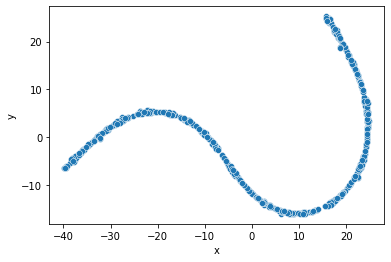

In [39]:
%matplotlib inline
tsne = TSNE()
tsne_fit = tsne.fit_transform(X_train.dropna())
tsne_pd = pd.DataFrame({"x": tsne_fit[:, 0], "y": tsne_fit[:,1]})
sns.scatterplot(x="x", y="y", data=tsne_pd)


In [40]:
features = df.columns.drop("target")

In [41]:
features

Index(['v_cont_0', 'v_cat_0', 'v_cat_1', 'v_cat_3', 'v_cont_5', 'v_cont_6',
       'v_cont_7', 'v_cont_8', 'v_cont_9', 'v_cont_10',
       ...
       'v_cont_95', 'v_cont_96', 'v_cont_97', 'v_cont_98', 'v_cont_99',
       'v_cont_100', 'v_cont_118', 'v_cont_119', 'v_cont_120', 'v_cont_125'],
      dtype='object', length=104)

In [42]:
X_train = X_train.fillna(-1)

In [43]:
####################### FEATURE SELECTION ####################

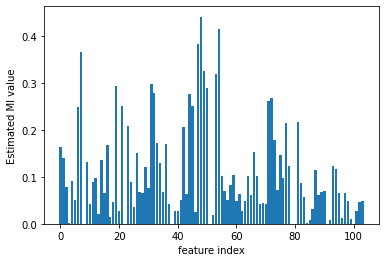

In [44]:
# feature selection
f_selector = SelectKBest(score_func=mutual_info_regression, k='all')
# learn relationship from training data
f_selector.fit(X_train, y_train)
# transform train input data
X_train_fs = f_selector.transform(X_train)
# transform test input data
#X_test_fs = f_selector.transform(X_test)
# Plot the scores for the features
plt.bar([i for i in range(len(f_selector.scores_))], f_selector.scores_)
plt.xlabel("feature index")
plt.ylabel("Estimated MI value")
plt.show()

In [45]:
# transform validation and test input data
X_validation = X_validation.fillna(-1)
X_test = X_test.fillna(-1)
X_validation_fs = f_selector.transform(X_validation)
X_test_fs = f_selector.transform(X_test)

In [46]:
f_selector.scores_.mean()

0.10994155191299887

In [47]:
f_selector.scores_.max()

0.442065130655827

In [48]:
f_selector.scores_.min()

0.0

In [49]:
f_selector.scores_.std(ddof=1)

0.1032884487690435

In [50]:
# indice of features whoch MI >= 0.1

feat_selected_idx = [i for i in range(len(f_selector.scores_)) if f_selector.scores_[i] >= 0.1]

In [51]:
len(feat_selected_idx)

41

In [52]:
feat_selected = features[feat_selected_idx]

In [53]:
feat_selected

Index(['v_cont_0', 'v_cat_0', 'v_cont_7', 'v_cont_8', 'v_cont_10', 'v_cont_15',
       'v_cont_17', 'v_cont_20', 'v_cont_22', 'v_cont_24', 'v_cont_27',
       'v_cont_30', 'v_cont_32', 'v_cont_33', 'v_cont_34', 'v_cont_35',
       'v_cont_37', 'v_cont_43', 'v_cont_45', 'v_cont_46', 'v_cont_48',
       'v_cont_49', 'v_cont_50', 'v_cont_51', 'v_cont_54', 'v_cont_55',
       'v_cont_56', 'v_cont_60', 'v_cont_65', 'v_cont_67', 'v_cont_68',
       'v_cont_72', 'v_cont_73', 'v_cont_74', 'v_cont_76', 'v_cont_78',
       'v_cont_79', 'v_cont_82', 'v_cont_88', 'v_cont_94', 'v_cont_95'],
      dtype='object')

In [54]:
############## TRAIN ###############

In [ ]:
# XGBREGRESSOR

In [88]:
data_dmatrix = xgb.DMatrix(data=X_train,label=y_train)

In [95]:
xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 10, alpha = 10, n_estimators = 100)

In [96]:
xg_reg.fit(X_train,y_train)

[10:01:41] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.3, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_delta_step=0,
             max_depth=10, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=12,
             num_parallel_tree=1, objective='reg:linear', predictor='auto',
             random_state=0, reg_alpha=10, reg_lambda=1, scale_pos_weight=1,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

In [98]:
preds_train = xg_reg.predict(X_train)

In [99]:
rmse_train = np.sqrt(mean_squared_error(y_train, preds_train))
r2_train = r2_score(y_train, preds_train)

In [101]:
print("The model performance for the training set")
print("-------------------------------------------")
print("RMSE of training set is {}".format(rmse_train))
print("R2 score of training set is {}".format(r2_train))

The model performance for the training set
-------------------------------------------
RMSE of training set is 0.1200863413950946
R2 score of training set is 0.7363432913829012


In [ ]:
# Regression 

In [66]:
model_poly = LinearRegression()
model_poly.fit(X_train, y_train)

LinearRegression()

In [68]:
# predicting on training data-set
y_train_predicted = model_poly.predict(X_train)
  
# evaluating the model on training dataset
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_predicted))
r2_train = r2_score(y_train, y_train_predicted)

In [91]:
print("The model performance for the training set")
print("-------------------------------------------")
print("RMSE of training set is {}".format(rmse_train))
print("R2 score of training set is {}".format(r2_train))

The model performance for the training set
-------------------------------------------
RMSE of training set is 0.12756438791926095
R2 score of training set is 0.7024838824135045


In [ ]:
############ Test on validation set ###########

In [ ]:
# XGB

In [102]:
# predicting on validation data-set
preds_validation = xg_reg.predict(X_validation)

In [105]:
rmse_validation_xgb = np.sqrt(mean_squared_error(y_validation, preds_validation))
r2_validation_xgb = r2_score(y_validation, preds_validation)

In [112]:
print("The XGB model performance for the validation set")
print("-------------------------------------------")
print("RMSE of validation set is {}".format(rmse_validation_xgb))
print("R2 score of validation set is {}".format(r2_validation_xgb))

The Regression model performance for the validation set
-------------------------------------------
RMSE of validation set is 0.14894556347957036
R2 score of validation set is 0.6308148012113435


In [ ]:
# Regression

In [110]:
# predicting on validation data-set
y_validation_predict = model_poly.predict(X_validation)

# evaluating the model on test dataset
rmse_validation = np.sqrt(mean_squared_error(y_validation, y_validation_predict))
r2_validation = r2_score(y_validation, y_validation_predict)


In [111]:

print("The Regression model performance for the validation set")
print("-------------------------------------------")
print("RMSE of validation set is {}".format(rmse_validation))
print("R2 score of validation set is {}".format(r2_validation))

The Regression model performance for the validation set
-------------------------------------------
RMSE of validation set is 0.13913420705305932
R2 score of validation set is 0.6778508630953868


In [ ]:
### It seems that looking at the RMSE and the R2 combined th best model will be xgboost

In [116]:
# predicting on validation data-set
preds_test = xg_reg.predict(X_test)

In [117]:
rmse_test_xgb = np.sqrt(mean_squared_error(y_test, preds_test))
r2_test_xgb = r2_score(y_test, preds_test)

In [118]:
print("The XGB model performance for the validation set")
print("-------------------------------------------")
print("RMSE of validation set is {}".format(rmse_test_xgb))
print("R2 score of validation set is {}".format(r2_test_xgb))

The XGB model performance for the validation set
-------------------------------------------
RMSE of validation set is 0.1325612839497887
R2 score of validation set is 0.6345403012178246
